In [3]:
import numpy as np
import yaml
import emcee
import matplotlib.pyplot as plt
import corner

In [1]:
pip install emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.4 MB/s eta 0:00:00


In [4]:
configfile = 'config.yaml'

In [2]:
pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch
import torch.nn as nn

In [6]:
class TwoHiddenLayerNN(nn.Module):
    def __init__(self, input_dim, output_dim, nodes):
        super(TwoHiddenLayerNN, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, 1024), 
                                   nn.ReLU(),
                                   nn.Linear(1024, 1024), 
                                   nn.ReLU(),
                                   nn.Linear(1024, output_dim), 
        )

    def forward(self, x):    
        return self.model(x)

In [17]:
em_model = TwoHiddenLayerNN(7, 400, 0)
em_model.load_state_dict(torch.load("trainedmodel"))
em_model.eval()

TwoHiddenLayerNN(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=400, bias=True)
  )
)

In [18]:
norms = np.load(f"norms.npy", allow_pickle=True).item()

In [19]:
def hard_prior(theta, params_prior):
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
def gaussian_prior(theta, params_prior):
    mu  = params_prior[:,0]
    std = params_prior[:,1]
    y = (theta - mu) / std
    return -0.5 * np.sum(y * y)

def ln_prior(theta, config):
    prior_flat = 0.
    prior_gauss = 0.
    
    if(len(config.flat_prior_indices) != 0):
        flat_prior_theta     = theta[config.flat_prior_indices]
        prior_flat    += hard_prior(flat_prior_theta, config.flat_prior_parameters)
    if(len(config.gaussian_prior_indices) != 0):
        gaussian_prior_theta = theta[config.gaussian_prior_indices]
        prior_gauss   += gaussian_prior(gaussian_prior_theta, config.gaussian_prior_parameters)
        
    return prior_flat + prior_gauss

def emulator_predict(theta, mask):
    x_norm = (theta-norms['x_mean'])/norms['x_std']
    y_predict = em_model(torch.tensor(x_norm, dtype=torch.float32))
    y_unnorm = y_predict.detach().numpy()*norms['y_std'] + norms['y_mean']
    return y_unnorm[mask]

def ln_lkl(theta, dv, mask, inv_cov):
    y_predict = emulator_predict(theta,mask)
    diff = dv-y_predict
    log_lk = - diff.T @ inv_cov @ diff
    return log_lk
    

def ln_posterior_wrapper(config, additional_dv_mask):
    
    mask = additional_dv_mask[config.mask_bool[:400]]
    dv = config.dv[mask]
    new_cov = config.cov[mask][:, mask]
    new_inv_cov = np.linalg.inv(new_cov)
    
    y_pred_mask = additional_dv_mask * config.mask_bool[:400]
    def ln_posterior(theta):
        return ln_lkl(theta, dv, y_pred_mask, new_inv_cov) + ln_prior(theta, config)
    return ln_posterior

In [20]:
norms['x_mean']

array([ 2.35153   ,  0.96823625, 71.41292257,  0.05075775,  0.25283232,
        0.1907344 ,  0.44348692])

In [21]:
class Config:
    def __init__(self, configfile):
        with open(configfile, "r") as stream:
            config_args = yaml.safe_load(stream)
        self.priors = config_args['priors']
        self.data   = config_args['data']
        self.get_prior_parameters()
        self.get_data()
    
    def get_prior_parameters(self):
        self.gaussian_prior_indices = []
        self.gaussian_prior_parameters = []

        self.flat_prior_indices    = []
        self.flat_prior_parameters = []

        ind = 0
        self.ndim = len(self.priors)
        
        for x in self.priors:
            prior = self.priors[x]
            dist  = prior['dist']
            if(dist=='gauss'):
                self.gaussian_prior_indices.append(ind)
                self.gaussian_prior_parameters.append([prior['loc'], prior['scale']])
            else:
                self.flat_prior_indices.append(ind)
                self.flat_prior_parameters.append([prior['min'], prior['max']])
            ind += 1
        
        self.gaussian_prior_parameters = np.array(self.gaussian_prior_parameters)
        self.flat_prior_parameters = np.array(self.flat_prior_parameters)

    def get_data(self):
        #read in DES measurement
        self.mask = np.genfromtxt(self.data['maskfile'])[:,1]
        self.mask_bool = self.mask.astype(bool)
        
        d = np.genfromtxt(self.data['dvfile'])[:,1]
        ndata = d.shape[0]
        
        cov =np.zeros((ndata,ndata))
        data = np.genfromtxt(self.data['covfile'])
        for i in range(0,data.shape[0]):
            cov[int(data[i,0]),int(data[i,1])] = data[i,2]
            cov[int(data[i,1]),int(data[i,0])] = data[i,2]
            
        self.cov = cov[self.mask_bool][:,self.mask_bool]
        self.dv  = d[self.mask_bool]
        
        self.inv_cov = np.linalg.inv(self.cov)

In [22]:
config = Config(configfile)

In [23]:
# Starting point for the emcee walkers with mean theta0 and rms theta_std

theta0 = 0.5 * (config.flat_prior_parameters[:,1] + config.flat_prior_parameters[:,0])
theta_std = 0.1 * (config.flat_prior_parameters[:,1]-config.flat_prior_parameters[:,0])

In [24]:
np.set_printoptions(suppress = True)

In [25]:
ndim, nwalkers = config.ndim, 20
pos0 = theta0 + theta_std * np.random.randn(nwalkers, ndim)

In [26]:
sampler_baseline = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_wrapper(config, np.ones(400, dtype=bool)))
sampler_baseline.run_mcmc(pos0, 15000);

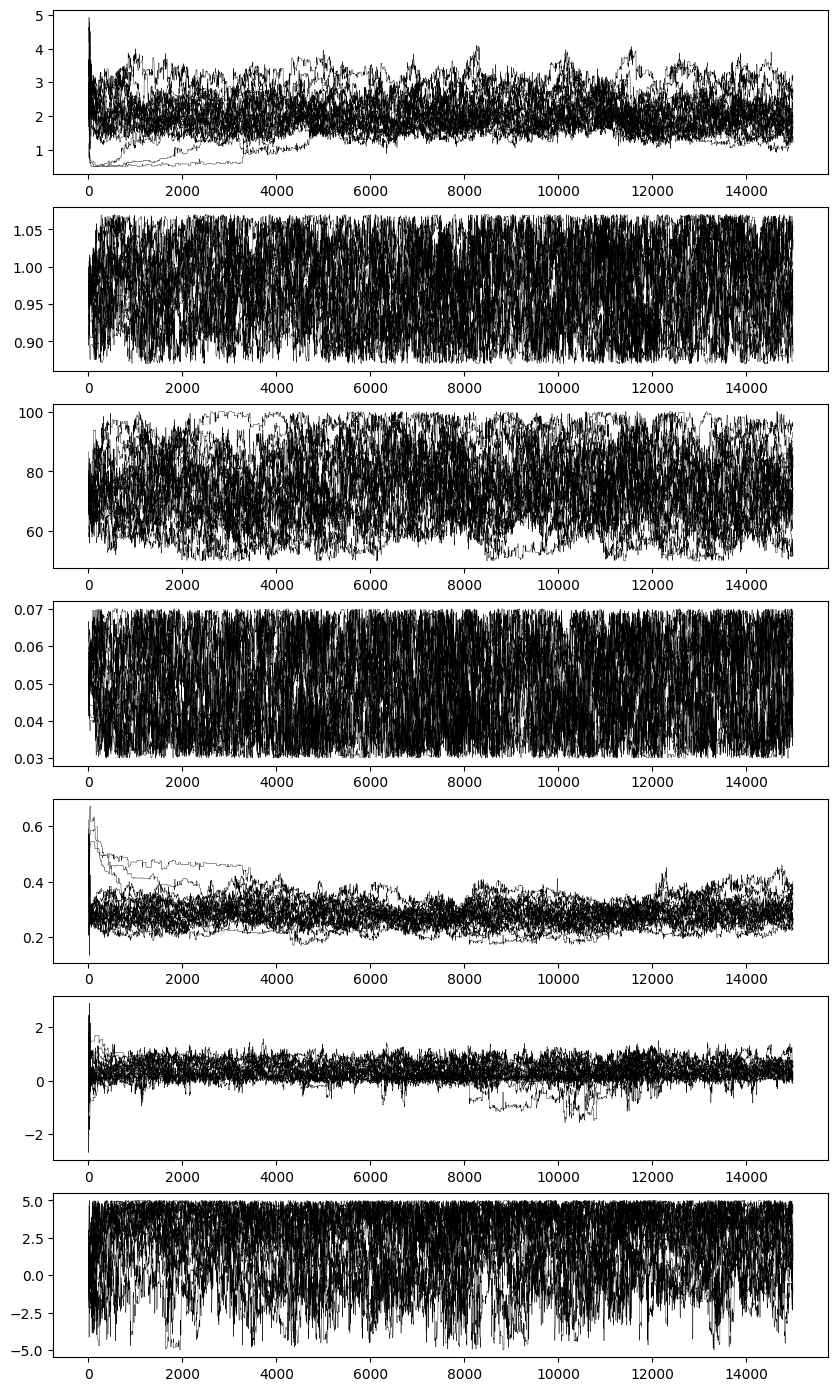

In [27]:
fig, ax = plt.subplots(7,1,figsize=(10,17.5))

for i in range(7):
    ax[i].plot(sampler_baseline.chain[:,:,i].T, 'k-', lw=0.3)

plt.show()    

In [28]:
baseline_samples = sampler_baseline.chain[:,1000:].reshape((-1,7))

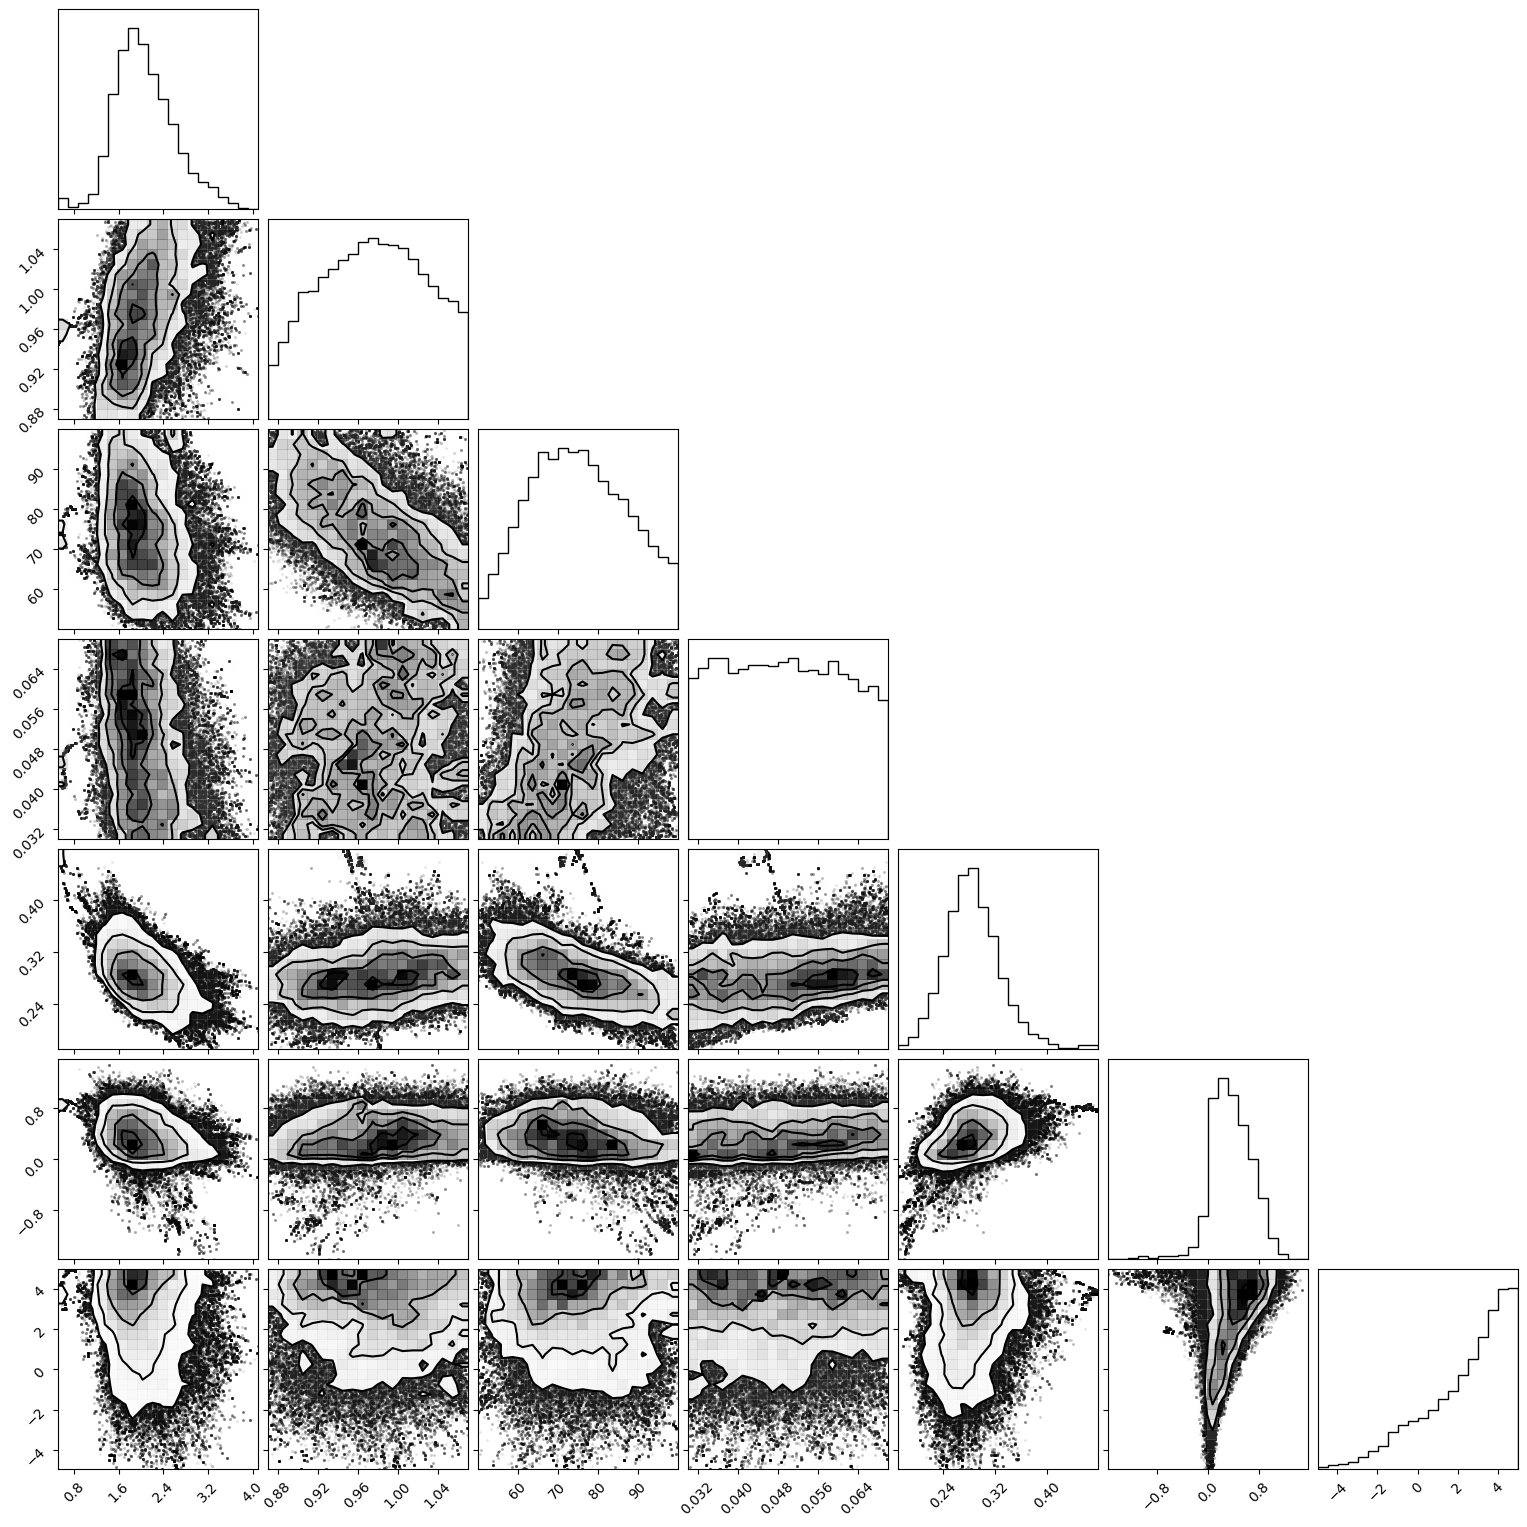

In [29]:
corner.corner(baseline_samples)
plt.show()

In [30]:
low_redshift_mask = np.zeros(400, dtype=bool)
low_redshift_mask[:40] = 1
low_redshift_mask[80:100] = 1
low_redshift_mask[200:240] = 1
low_redshift_mask[280:300] = 1

In [31]:
sampler_low_redshift = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_wrapper(config, low_redshift_mask))
sampler_low_redshift.run_mcmc(pos0, 15000);

In [32]:
high_redshift_mask = np.zeros(400, dtype=bool)
high_redshift_mask[140:200] = 1
high_redshift_mask[340:400] = 1

In [33]:
sampler_high_redshift = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_wrapper(config, high_redshift_mask))
sampler_high_redshift.run_mcmc(pos0, 15000);

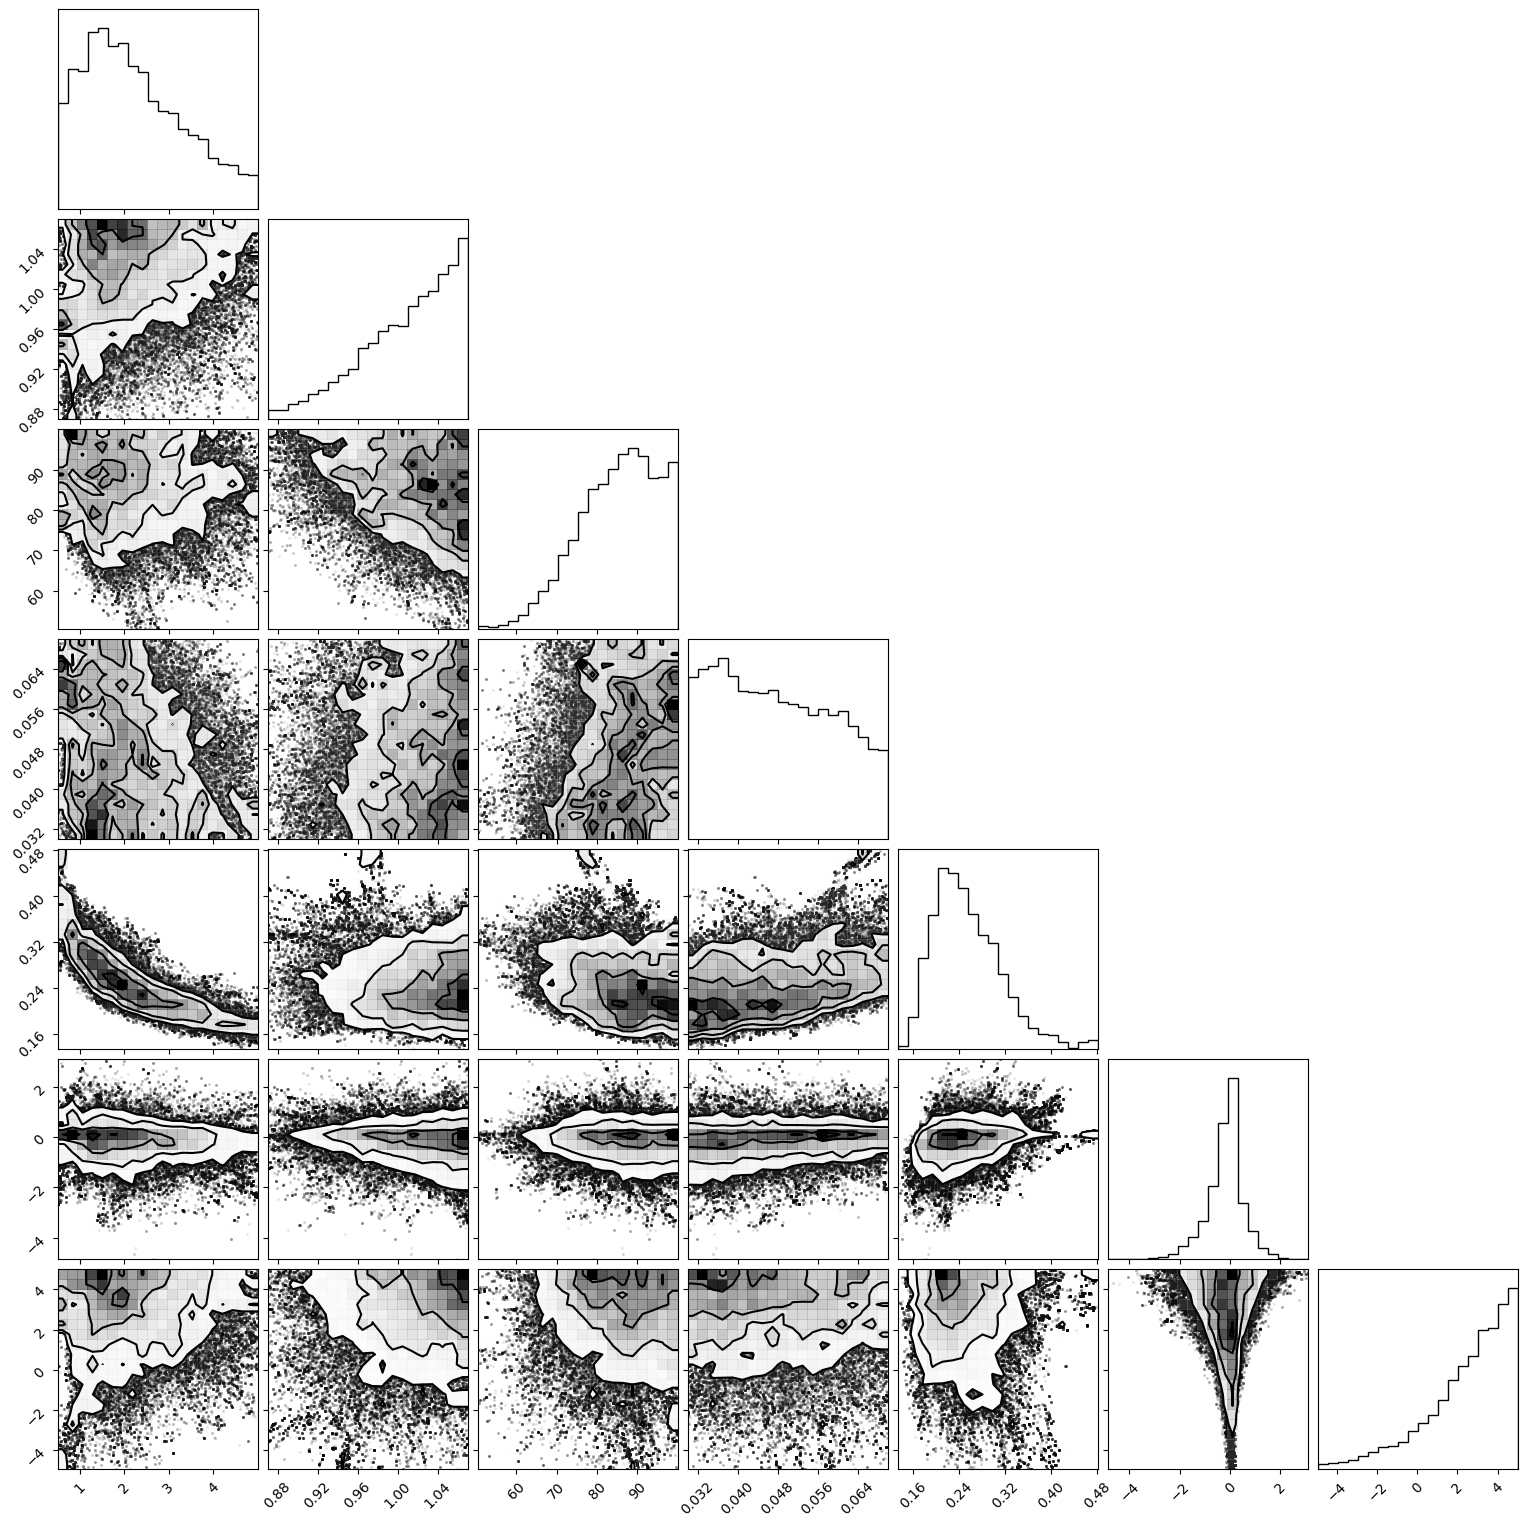

In [34]:
samples_low_redshift = sampler_low_redshift.chain[:,5000:].reshape((-1,7))
corner.corner(samples_low_redshift)
plt.show()

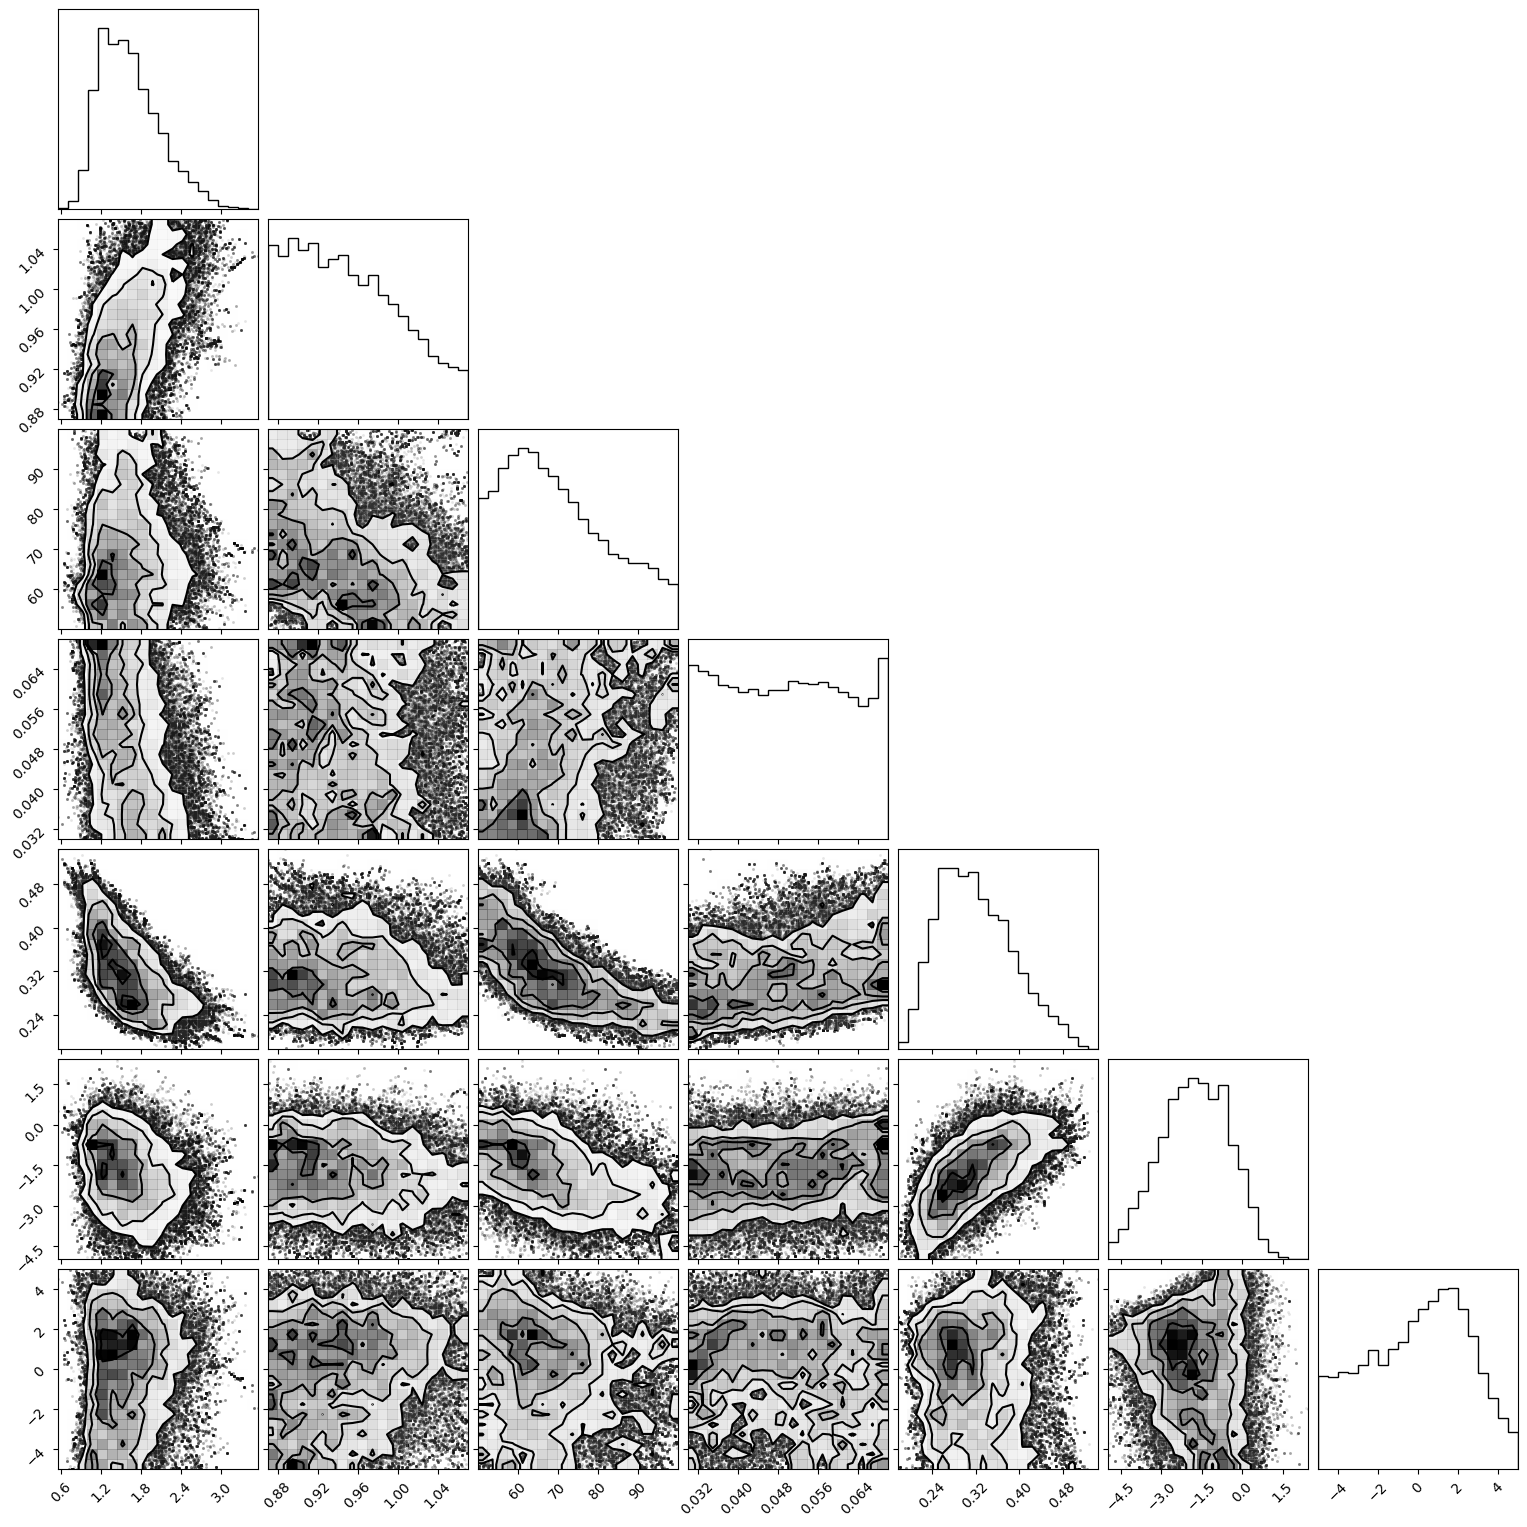

In [35]:
samples_high_redshift = sampler_high_redshift.chain[:,5000:].reshape((-1,7))
corner.corner(samples_high_redshift)
plt.show()

In [36]:
samples_high_redshift

array([[ 1.48957618,  0.91859152, 74.41140358, ...,  0.29212382,
        -3.11023455, -1.73496338],
       [ 1.48957618,  0.91859152, 74.41140358, ...,  0.29212382,
        -3.11023455, -1.73496338],
       [ 1.48957618,  0.91859152, 74.41140358, ...,  0.29212382,
        -3.11023455, -1.73496338],
       ...,
       [ 1.24026447,  0.89560228, 84.88210895, ...,  0.27656996,
        -3.31411842,  1.90560794],
       [ 1.24026447,  0.89560228, 84.88210895, ...,  0.27656996,
        -3.31411842,  1.90560794],
       [ 1.24026447,  0.89560228, 84.88210895, ...,  0.27656996,
        -3.31411842,  1.90560794]])

In [39]:
np.save("highz", samples_high_redshift)

In [40]:
np.save("lowz", samples_low_redshift)